# Challenge 2
### Categorizing customer behavior & developing strategy
------------------

**Problem Statement:** Analyze the given dataset and answer the following questions:

1. On a high level, identify how they discover books from the discover screen. Walk us
through your thinking, attach the code. We suggest using Jupyter Notebook for steps like
these where you need to provide the code, the outcome and your comments.
2. Identify high level customer segments based on how they discover content and the type
of content they are interested in. Walk us through your thinking, attach the code.
3. Based on your findings, recommend how the discover screen setup can be more
personalized for each customer segment.
4. Develop a high level strategy to implement the recommended screen setup.

## Methodology
----------
1. Use the same analysis strategy like previos challenge but this time narrow down only on `discover` events.
2. Make use of `book_index.json` data to gather insights on book types.
3. We'll derive some new feature to analyse users behaviour on current recommendation events.


## Summary : Dataset
--------

1. In addition to data used in previous challenge, `book_index.json` contains meta information about a sample of books.
2. It contains information for about 2832 unique books such as title, author, description, keywords etc.
3. In discover screen, around 72% of the books are in english and the rest 28% are in german. Looks like majority of the blinkist users are english speakers.

In [1]:
# load libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

pd.set_option('display.max_columns', 500)

In [2]:
# load data
discover_events = pd.read_csv('discover_events.csv', parse_dates=['dim_date_id','event_timestamp','arrival_timestamp'])
book_json = pd.read_json('books_index.json')

## Prepare the data
-----
Here we will filter the data and keep only `discover` events. We'll join both the datasets. 
Also, we'll create a new feature based on `screen-url` which represents the recommendation event/channel, the user interacted with. Our hypothesis is, to observe different behaviour in different channels.

In [3]:
# filter data
discover_events_2 = discover_events[discover_events['category'] == 'flex-discover']

# extract url type
discover_events_2['category_l2'] = discover_events_2['screen_url'].str.split('/',2).str[2]

# join datasets
discover_events_2 = discover_events_2.merge(book_json, how='left', left_on='content', right_on='slug')

/anaconda3/envs/bunnies/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


## Univariate Analysis
------
Let's do a quick univariate analysis on some features.

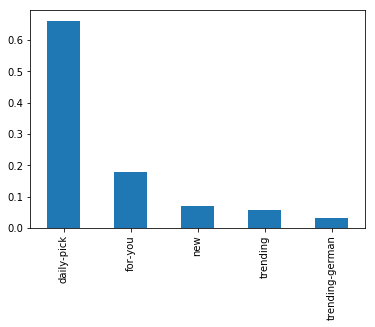

In [4]:
discover_events_2['category_l2'].value_counts(normalize=True).plot(kind='bar')

We see that, around 65% of the `discover` users, prefer using `daily-pick` for explore/discover new books. It would be better to see how this varies with user action i.e. does `daily-pick` also results in `add-books` events? Lets see in further analysis.

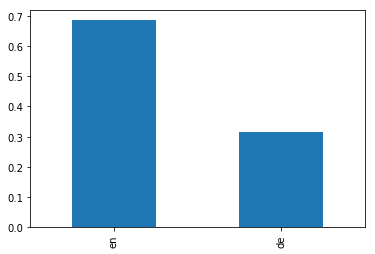

In [111]:
discover_events_2['language'].value_counts(normalize=True).plot(kind='bar')

As said above, around 70% of the books in this dataset are in english.

## Multivariate analysis


### `action vs category` plot

/anaconda3/envs/bunnies/lib/python2.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


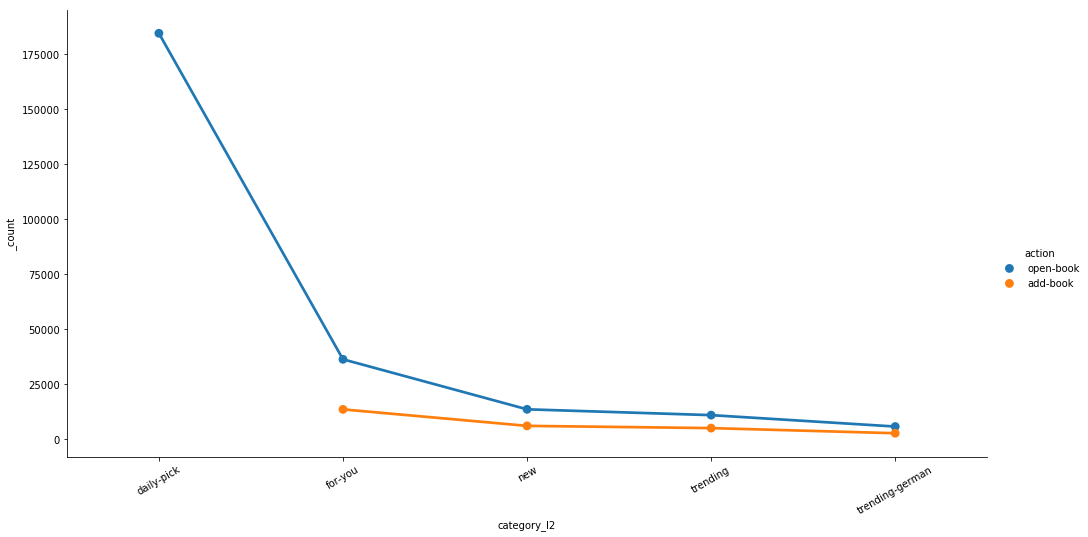

In [120]:
f = discover_events_2.groupby(['category_l2','action']).size().reset_index()
f = f.rename(columns={0: '_count'})

g = sns.catplot(x="category_l2", 
            y="_count", 
            hue="action", 
            kind="point", 
            data=f,
            size=7, aspect=2)
g.set_xticklabels(rotation=30)

We observe the following insights:

1. All the users respond to `daily-pick` recommendations by doing `open-book` event.
2. However, they don't add books. `for-you` recommendation seems to be better than `daily-pick` in case of `add-book` performance as they have the highest proportion of `add-book` events among all other event types i.e. when users add books in their libraries.

Let's see now, which author/books are the ones which users add to their library.

### `top-20` authors

/anaconda3/envs/bunnies/lib/python2.7/site-packages/seaborn/categorical.py:3692: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


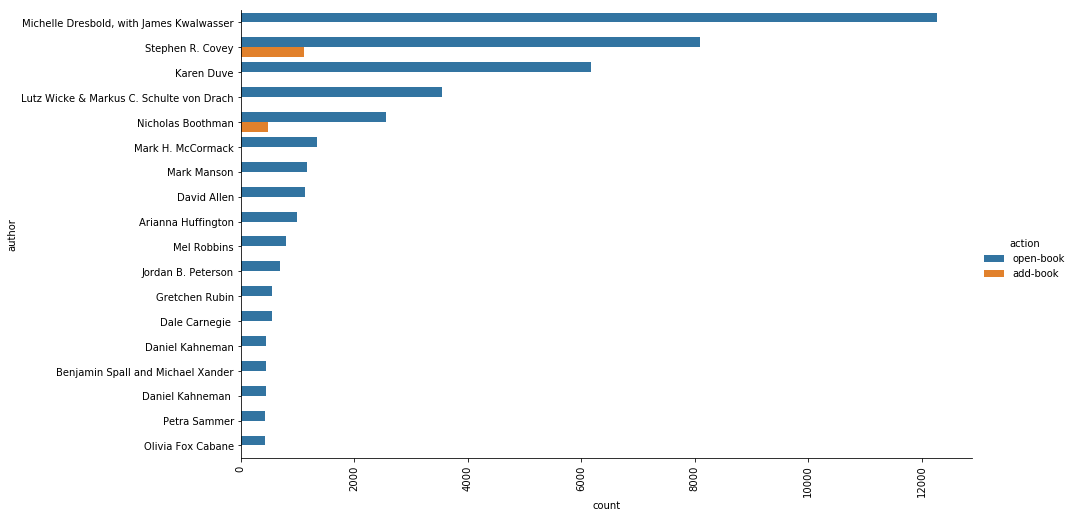

In [123]:
# top 20 authors
author_books = discover_events_2.groupby(['author','action']).size().nlargest(20).reset_index()
author_books.columns = ['author','action','count']

g = sns.catplot(x="count", 
            y="author", 
            hue="action", 
            kind="bar", 
            data=author_books,
            size=7, aspect=2, orient="h")
g.set_xticklabels(rotation=90)

We observe the following:
 * Books by *Stephen R Covey* of the fame *7 habits of highly effective people* and N. Boothman are being added by users. 
 * For rest other authors, people view their books but don't seem to add them.  
 * A better view of this plot could be given by analysing these authors individually. Are the other authors relatively new ? Do they not have any famous books? 
 
Let's look at which books are being added more.

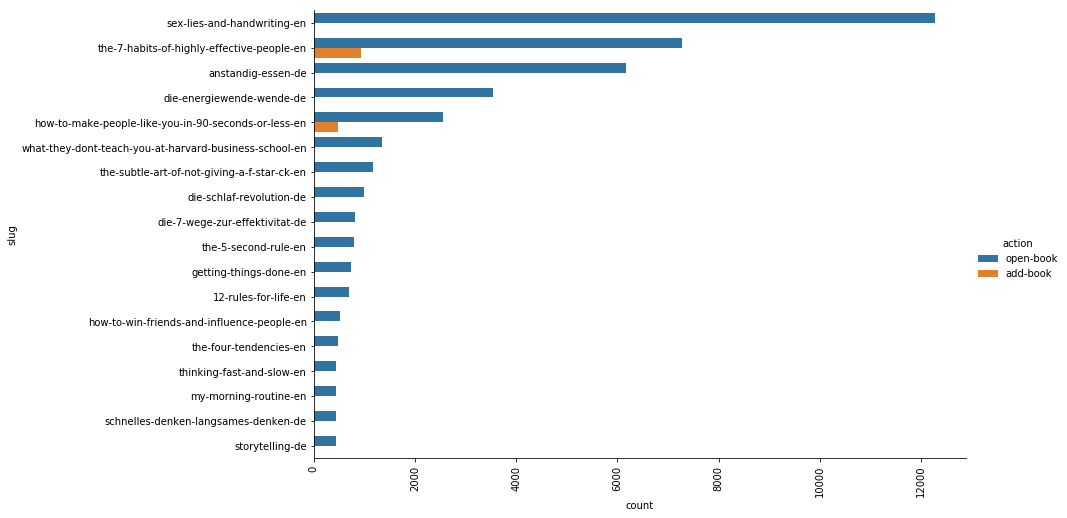

In [99]:
# top 20 books
books = discover_events_2.groupby(['slug','action']).size().nlargest(20).reset_index()
books.columns = ['slug','action','count']

g = sns.catplot(x="count", 
            y="slug", 
            hue="action", 
            kind="bar", 
            data=books,
            size=7, aspect=2, orient="h")
g.set_xticklabels(rotation=90)

This plot seems to be inline with earlier [author plot](#top-20-authors) we saw. These books actually belong to the above two authors we mentioned of. 

But, why are the users adding these books ? Do they have something in common ? Let's take a deeper dive in the content of these books to understand what the users like. Now, we'll analyse the book categories and see how they vary for `action-type`.

## Category analysis

We will use `word-cloud` to visualize books from which category are added more or opened. We'll need to process the `categories` text accordindly.  

### `add-book` events

In [30]:
# filter data and keep add-book events
add_book_events = discover_events_2[discover_events_2['action'] == 'add-book']

cats = add_book_events['categories'].tolist()

In [31]:
# clean the data
cats = [i for i in cats if str(i) != 'nan']
cats = [str(re.sub(r'[^\w\s]','',i)) for s in cats for i in s]
cats = ['_'.join(x.split()) for x in cats]
cats = ' '.join(cats)

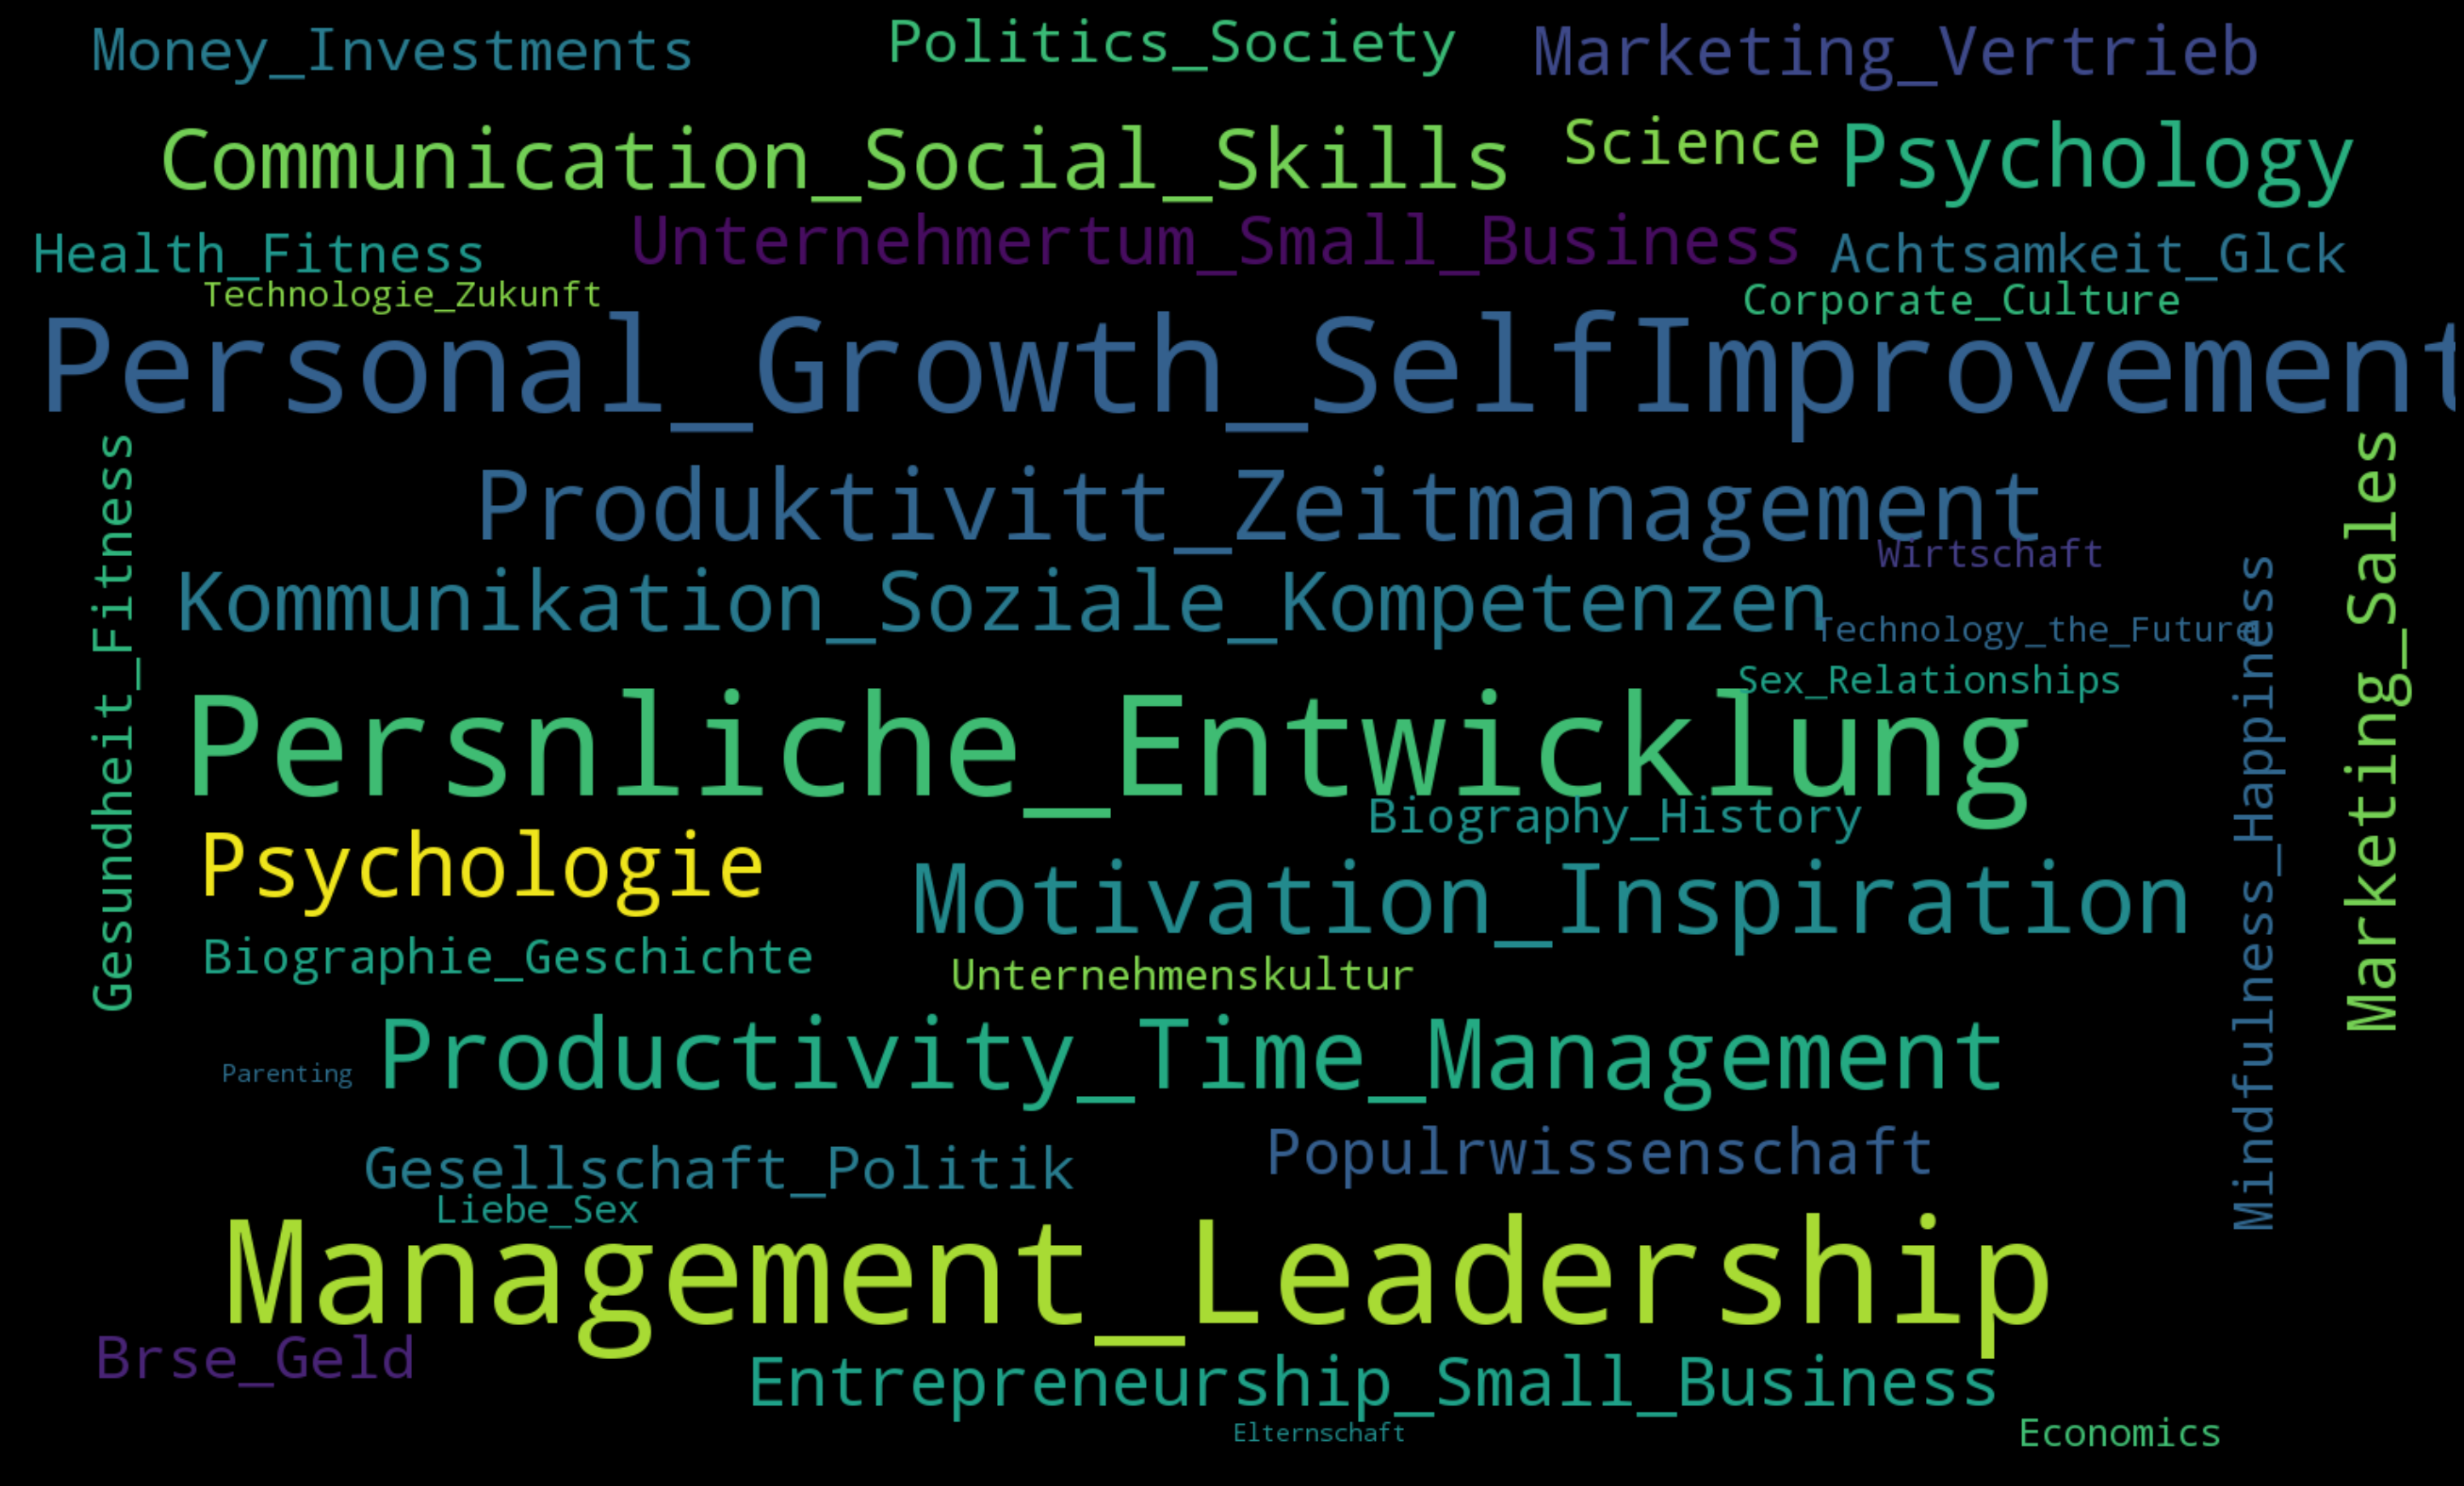

In [32]:
# draw wordcloud
wordcloud = WordCloud(max_font_size=30, 
                      max_words=100, 
                      background_color="black",
                      width = 500,
                      height = 300,
                     scale = 3,
                     collocations=False).generate(cats)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We see that users tend to add books from categories like `Personal Growth SelfImprovement`, `Management_Leadership`, `Productivity Time Management`. Let's see how different it looks like for `open-book` events.

### `open-book` events



In [33]:
# filter the data
open_book_events = discover_events_2[discover_events_2['action'] == 'open-book']
cats = open_book_events['categories'].tolist()

In [34]:
# clean the data
cats = [i for i in cats if str(i) != 'nan']
cats = [str(re.sub(r'[^\w\s]','',i)) for s in cats for i in s]
cats = ['_'.join(x.split()) for x in cats]
cats = ' '.join(cats)

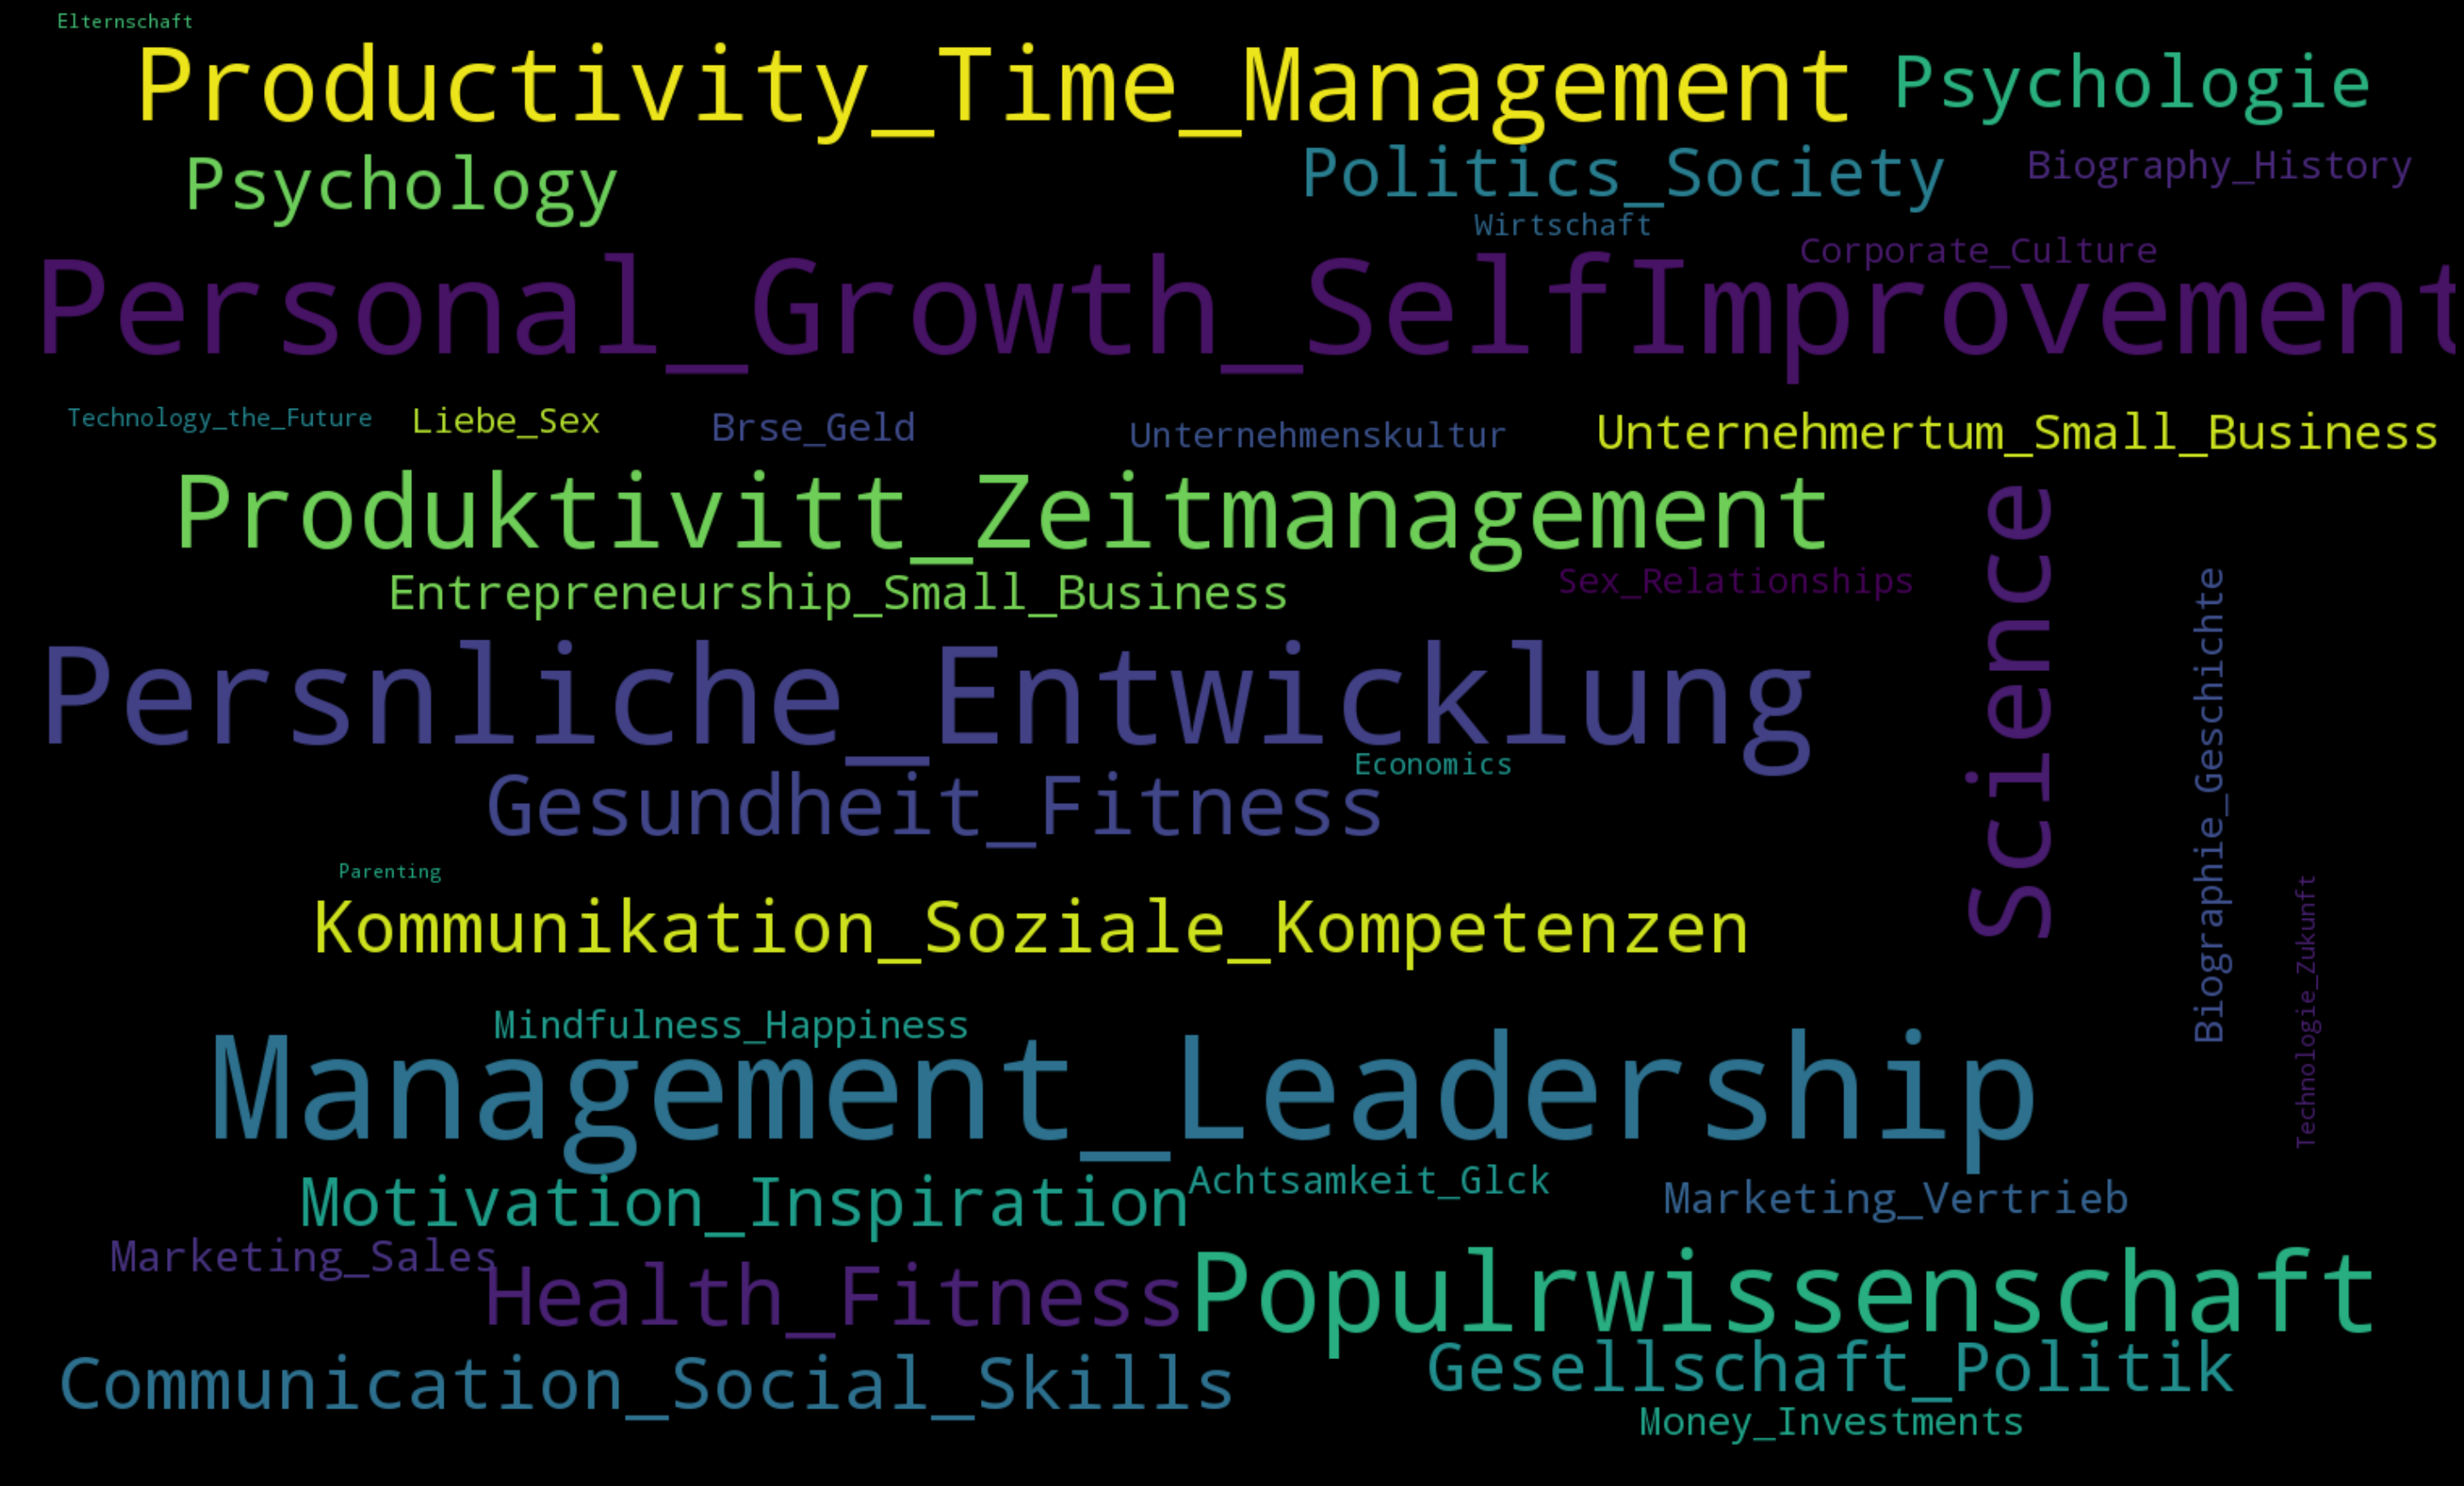

In [35]:
wordcloud = WordCloud(max_font_size=30, 
                      max_words=100, 
                      background_color="black",
                      width = 500,
                      height = 300,
                     scale = 3,
                     collocations=False).generate(cats)

fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

We don't see much difference than before except categories like `Science`, `Social Communication`, `Fitness` have surfaced.

## Insights

Based on our analysis we infer the following:

1. In the discover screen, users open books using `daily-picks` section/channel but they don't add them to their library. `for-you` section seems more effective when it comes to adding books by the users.  

2. We saw that users are mainly interested in topics like `Personal Growth SelfImprovement`, `Management_Leadership`, `Productivity Time Management` and popular books like `7 habits of highly effective people`, where interest is defined by `add-book` events.  

3. Discover screen can be more personalised using following ways:
 * Creating collections and showing them as horizontal sliders (spotify style) in the discover screens.
 * These collections can be made based on:
     * Popular books in category selected by users during sign up
     * More books by authors whose books the user has already read
     * Similar books to the books user has added
     * Recommend books from users who are similar to you
     
4. A good recommendation strategy should be able to help the user discover fresh content without making much effort. Also, along with showing simillar stuff, it should also able to introduce the `serendipity` flavour in user content discovery experience. In our case, a simple recommendation strategy could be as follows (further adding from challenge 1 solution):
 * We can split the content into multiple categories such as :
     * Heuristics Based Models
         * Fresh releases (new books)
         * Trending books of the week 
         * Top rated books
         * Best selling books
         * #Count based popularity in each category
     * ML Based recommendation
         * Item to item recommendations
         * User to item recommendations
 * Based on the user case, these models can be deployed at different levels in a user's journey to help the user easily identiy where to go next. 